# Homework 2
## Jincheng(Eric) Huang

Suppose capital depreciated fully in each period. The Bellman equation describing the agent's problem is as follows:
$$V(z,k)=\max_{k'} \log(f(z,k)-k') + \beta \mathbb E_{z'|z} V(z',k')$$
By the FOC and Envelope condition, we can get the following Euler equation:
$$\frac{1}{f(z,k)-k'} = \beta \mathbb E\Bigg[\frac{f'(z',k')}{f(z',k')-k'(k')}\Bigg].$$

## (1). Approximate capital policy function using piecewise linear function
The steps for policy-time iteration using functional approximation are the following:
1. Set capital grid $K=[K_1,K_2,...,K_n]$, guess capital policy function $K'(z,k)$ and error tolerance $\bar\epsilon$.
2. Solve for the system of non-linear equations at grid points  $\forall j\in{1,...,n}$:
$$R(z,k_j)\equiv \frac{1}{f(z,k_j)-K'(z,k_j)} - \beta \mathbb E\Bigg[\frac{f'(z',K'(z,k_j))}{f(z',K'(z,k_j))-L(z',K'(z,k_j);k,K')}\Bigg] = 0$$ where $L(s,x;k,K')$ is the interpolated value of the policy function K' at states $z=s,k=x$. <br>
In the discrete shock case, states are iid and occur with equal probabilities, so the error function $$R(z,k_j)\equiv \frac{1}{f(z,k_j)-K'(z,k_j)} - \frac{\beta}{2} \Bigg[\frac{f'(1,K'(z,k_j))}{f(1,K'(z,k_j))-L(1,K'(z,k_j);k,K')} + \frac{f'(2,K'(z,k_j))}{f(2,K'(z,k_j))-L(2,K'(z,k_j);k,K')}\Bigg]$$
3. Calculate error $\epsilon = \max_{z,j} R(z,k_j)$. Continue iteration if $\epsilon > \bar\epsilon$. Stop otherwise.

In [1]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, root
from matplotlib import pyplot as plt
import numpy.polynomial.chebyshev as cheb
import numpy as np

# Production function
# z: aggregate state (TFP), k: current capital
def f(z,k):
    if z == 1:
        return 0.9*k**0.3 + 0.3*k
    else:
        return 1.1*k**0.3 + 0.9*k

# Derivative of production function
def fp(z,k):
    if z == 1:
        return 0.27*k**(-0.7) + 0.3
    else:
        return 0.33*k**(-0.7) + 0.9

# Residual function evaluated at k=x
# kp: capital policy function (nk*nz)
def R(x,z,beta,k,kp,kgrid):
    lhs = 1 / (f(z,k)-x)
    L1 = interp1d(kgrid,kp[:,0])
    L2 = interp1d(kgrid,kp[:,1])
    rhs = beta * 0.5*(fp(1,x)/(f(1,x)-L1(x)) + fp(2,x)/(f(2,x)-L2(x)))
    return abs(lhs-rhs)                 

nk = 30                             # number of capital grid points
kmin = 0.1                          # minimum capital
kmax = 1.5                          # maximum capital
kgrid = np.linspace(kmin,kmax,nk)
tol = 1e-5                          # tolerance level for error
gk = np.zeros((nk,2))               # capital policy function
maxDiff = np.inf
beta = 0.9

# Main step: find capital policy that satisfies the Euler equation
while maxDiff > tol:
    gkTemp = np.zeros((nk,2))       # capital policy in the next iteration
    residuals = np.zeros((nk,2))
    for ik in range(nk):
        for iz in range(2):
            k = kgrid[ik]
            z = iz + 1
            ksol = fsolve(R,0.1,args=(z,beta,k,gk,kgrid))
            gkTemp[ik,iz] = ksol
    
    for ik in range(nk):
        for iz in range(2):
            k = kgrid[ik]
            z = iz + 1
            residuals[ik,iz] = R(gkTemp[ik,iz],z,beta,k,gkTemp,kgrid)
            
    maxDiff = abs(residuals).max()
    gk = np.copy(gkTemp)

# Plot the policy functions
plt.plot(kgrid,gk[:,0],label='z=1')
plt.plot(kgrid,gk[:,1],label='z=2')
plt.ylim([min(kgrid),max(kgrid)])
plt.xlabel(r"$k$")
plt.ylabel(r"$k'$")
plt.legend()
plt.show()


<Figure size 640x480 with 1 Axes>

## (2). Approximate capital policy function using Chebyshev polynomial and collocation points
The steps are the following:
1. Set grid points $K=[K_1,K_2,...,K_n]$ by choosing $n,K_{min},K_{max}$ and setting $K_j = (Z^n_j+1)(K_{max}-K_{min})/2+K_{min}$, where $Z^n_j,j=1,...,n$ are the Chebyshev zeros of the polynomials. Guess coefficients ${\theta^i_j}$ for Chebyshev basis functions ${T_1(x),...,T_n(x)}$.
2. Solve for $\theta$'s in the system of non-linear equations, $\forall j\in{1,...,n}$:
$$R(z_i,K_j;\theta)\equiv \frac{1}{f(z_i,k_j)-K'(z_i,k_j;\theta)} - \beta \mathbb E\Bigg[\frac{f'(z',K'(z_i,k_j;\theta))}{f(z',K'(z_i,k_j;\theta))-K'(z',K'(z_i,k_j;\theta);\theta)}\Bigg] = 0$$ where $K'(z_i,k_j;\theta)=\sum_j \theta^i_j T_j(x)$ Chebyshev approximations of the policy function.
3. (a) Calculate error: $\epsilon = \max_{i,j} R_{i,j}$ <br>
(b) Stop if $\epsilon<\bar \epsilon$, otherwise reiterate.

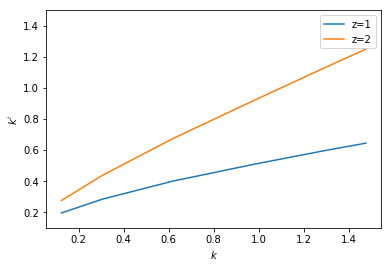

In [2]:
# Residual function of the Euler equation
def R_chebyshev(x,n,beta,kgrid,kmin,kmax):
    res = np.zeros((n*2,1))                      # residuals of Euler equations evaluated at grid points
    coeff = np.zeros((2,n))                      # coefficients of Chebyshev polynomials
    coeff[0,:] = x[0:n]
    coeff[1,:] = x[n:]
    
    # Create Chebyshev basis functions
    z = -np.cos((2*(np.linspace(1,n,n))-1)/(2*n)*np.pi)  # Chebyshev zeros in [-1,1]
    T_k = np.ones((n,n))                                 # columns are polynomials of different degrees
    T_k[:,1] = z
    for i in range(2,n):
        T_k[:,i] = 2*z*T_k[:,i-1] - T_k[:,i-2]
    
    lhs = np.zeros((2*n,))
    rhs = np.zeros((2*n,))
    
    # Iterate over the two aggregate states
    for iz in range(2):
        gk = np.zeros((n,1))                             # capital policy function at current z
        
        # Iterate over capital in this period
        for ik in range(n):
            k = kgrid[ik]
            kp = coeff[iz,:].dot(T_k[ik,:])
            
            # Make sure capital next period is in the [kmin,kmax] range, and consumption > 0
            kp = max(kp,kmin+0.01)
            kp = min(kp,kmax-0.01,f(iz+1,k)-0.01)            
            gk[ik] = kp
        
        gk_scaled = (2*gk-(kmin+kmax))/(kmax-kmin)      # rescale capital policy to the [-1,1] range
        
        # Create Chebyshev basis functions evaluated at capital in the next period
        T_g_k = np.ones((n,n))
        T_g_k[:,[1]] = gk_scaled
        for i in range(2,n):
            T_g_k[:,[i]] = 2*gk_scaled*T_g_k[:,[i-1]] - T_g_k[:,[i-2]]
        
        # Iterate over capital in this period
        for ik in range(n):
            k = kgrid[ik]
            kpp = np.zeros((2,1))                      # capital two periods later
            
            # Iterate over aggregate states in the next period
            for izp in range(2):              
                kpp[izp] = coeff[izp,:].dot(T_g_k[ik,:])
                
                # Make sure capital two periods later is also in [kmin,kmax], and consumption in the next period > 0
                kpp[izp] = max(kpp[izp],kmin+0.01)
                kpp[izp] = min(kpp[izp],kmax-0.01,f(izp+1,gk[ik])-0.01)
            
            lhs[iz*n+ik] = 1 / (f(iz+1,k)-gk[ik])      # left hand side of the Euler equation
            rhs[iz*n+ik] = beta * 0.5 * (fp(1,gk[ik])/(f(1,gk[ik])-kpp[0]) + fp(2,gk[ik])/(f(2,gk[ik])-kpp[1]))
                                                       # right hand side of the Euler equation
            
    res = abs(lhs - rhs)
    return res

###################################################
maxDiff = np.inf
n_list = np.array((3,4,5,6))                           # gradually increase the degree of Chebyshev polynomials (otherwise hard to converge)
n = min(n_list)
coeff = np.vstack((np.array((0.3)),np.zeros((n-1,1)),np.array((0.8)),np.zeros((n-1,1))))
                                                       # coefficients of the Chebyshev polynomials (coefficient of the constant term should be close to steady state capital)
for n in n_list:
    z = -np.cos((2*(np.linspace(1,n,n))-1)/(2*n)*np.pi)   # Chebyshev zeros
    kgrid_colloc = kmin + (z+1)*(kmax-kmin)/2             # capital grid
    
    if n > min(n_list):
        coeff = np.vstack((np.array((0.3)),np.zeros((n-1,1)),np.array((0.8)),np.zeros((n-1,1))))
        coeff[0:nOld] = coeff_sol[0:nOld].reshape(nOld,1)
        coeff[n:n+nOld] = coeff_sol[nOld:].reshape(nOld,1)
    
    # Solve for the coefficients
    while maxDiff > tol:
        coeff_sol = fsolve(R_chebyshev,coeff,args=(n,beta,kgrid_colloc,kmin,kmax))
        residuals = R_chebyshev(coeff_sol,n,beta,kgrid_colloc,kmin,kmax)
        maxDiff = residuals.max()
        
    maxDiff = np.inf
    nOld = n

# Recover policy functions from the coefficients
T_k = np.ones((n,n))
z = -np.cos((2*(np.linspace(1,n,n))-1)/(2*n)*np.pi)
kgrid_colloc = kmin + (z+1)*(kmax-kmin)/2
T_k[:,1] = z
for i in range(2,n):
    T_k[:,i] = 2*z*T_k[:,i-1] - T_k[:,i-2]

gk = np.zeros((n,2))                                       # capital policy function
for iz in range(2):    
    for ik in range(n):
        k = kgrid[ik]
        kp = coeff[iz*n:(iz+1)*n].T.dot(T_k[ik,:])
        gk[ik,iz] = kp

# Plot the results
plt.plot(kgrid_colloc,gk[:,0],label='z=1')
plt.plot(kgrid_colloc,gk[:,1],label='z=2')
plt.ylim([min(kgrid),max(kgrid)])
plt.xlabel(r"$k$")
plt.ylabel(r"$k'$")
plt.legend()
plt.show()
